## ERDDAP NC Sort
netcdf files from tabular data is serialized and hard to use in xarray when there are multiple depths 

In [ ]:
#code below is enhanced by gemini after building working code

Opening /Users/bell/Downloads/datasets_Mooring_22bs8a_final_f309_c29e_7cdb.nc...
Restructuring data...

Final Dataset Structure:
<xarray.Dataset> Size: 997kB
Dimensions:      (time: 8905, depth: 13)
Coordinates:
  * time         (time) datetime64[ns] 71kB 2022-09-08 ... 2023-09-14
  * depth        (depth) float64 104B 16.0 18.0 20.0 23.0 ... 55.0 60.0 65.0
Data variables:
    temperature  (time, depth) float64 926kB 8.935 8.934 8.925 ... -1.516 -1.536

Saving processed data to datasets_Mooring_gridded.temperature.nc...
Save complete.

Plotting...


/Users/bell/mambaforge/envs/p312/lib/python3.12/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'par' has multiple fill values {1e+35, -9999.0} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/Users/bell/mambaforge/envs/p312/lib/python3.12/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'oxygen_saturation' has multiple fill values {1e+35, -9999.0} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/Users/bell/mambaforge/envs/p312/lib/python3.12/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'oxygen_concentration' has multiple fill values {1e+35, -9999.0} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/Users/bell/mambaforge/envs/p312/lib/python3.12/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'Water_Depth' has multiple fill values {1e+35, -9999.0} defined, decoding all values to NaN.
  var = coder.decode(var, name

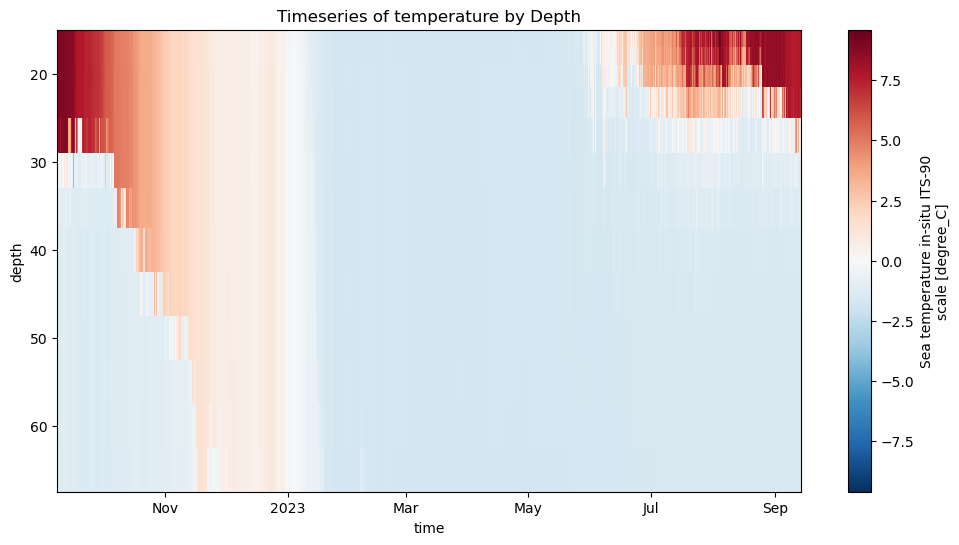

In [88]:
#!/usr/bin/env python
# coding: utf-8

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

def process_erddap_nc(file_path, parameter, resample_freq='1h'):
    """
    Reads a tabular ERDDAP NetCDF, pivots it to a Time x Depth grid,
    and returns a clean Xarray Dataset.
    """
    print(f"Opening {file_path}...")
    
    # Load dataset (use open_dataset for lazy loading, load() only if needed)
    ds = xr.open_dataset(file_path)

    # Swap dimension to time if 'row' exists (common in ERDDAP tabular response)
    if 'row' in ds.dims:
        ds = ds.swap_dims({'row': 'time'})

    print("Restructuring data...")
    
    # 1. Convert to Pandas, but ONLY the necessary columns to save memory
    #    We need time (index), depth (columns), and the data value.
    #    Using 'timeseries_id' ensures unique instruments are separated.
    cols_to_keep = [parameter, 'depth', 'timeseries_id']
    
    # Check if columns exist
    valid_cols = [c for c in cols_to_keep if c in ds.variables]
    df = ds[valid_cols].to_dataframe()

    # 2. Clean missing data
    df = df.dropna(subset=[parameter])

    # 3. Pivot: This replaces the 'for' loop. 
    #    It turns 'depth' into columns and 'time' into the index automatically.
    #    We use 'depth' as columns so the final xarray has a Depth dimension.
    #    (If multiple instruments share a depth, consider using 'timeseries_id' as columns instead)
    pivoted_df = df.pivot_table(
        index='time', 
        columns='depth', 
        values=parameter
    )

    # 4. Resample (e.g., hourly mean)
    #    This aligns the time index to a regular grid
    resampled_df = pivoted_df.resample(resample_freq).mean()

    # 5. Convert back to Xarray
    #    Pandas columns become the 'depth' dimension, Index becomes 'time'
    ds_final = xr.DataArray(
        resampled_df, 
        name=parameter,
        dims=('time', 'depth'),
        coords={'time': resampled_df.index, 'depth': resampled_df.columns}
    ).to_dataset()

    # Add attributes back for context (optional)
    ds_final[parameter].attrs = ds[parameter].attrs
    
    return ds_final

# --- Main Execution ---

file_path = '/Users/bell/Downloads/datasets_Mooring_22bs8a_final_f309_c29e_7cdb.nc'
target_param = 'temperature'

# Define the output filename
output_filename = f'datasets_Mooring_gridded.{target_param}.nc'

try:
    # 1. Process the data using the function we created
    final_ds = process_erddap_nc(file_path, target_param, resample_freq='1h')
    
    print("\nFinal Dataset Structure:")
    print(final_ds)

    # 2. Save to a new NetCDF file
    print(f"\nSaving processed data to {output_filename}...")
    final_ds.to_netcdf(output_filename)
    print("Save complete.")

    # 3. Plotting
    print("\nPlotting...")
    plt.figure(figsize=(12, 6))
    final_ds[target_param].T.plot(yincrease=False)
    plt.title(f"Timeseries of {target_param} by Depth")
    plt.show()

except FileNotFoundError:
    print("File not found. Check the path.")
except KeyError as e:
    print(f"Key Error: {e}. Check if the parameter '{target_param}' exists in the file.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")